### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 3 мая 2021, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 03 мая, -4 балла после 08:30 10 мая, -6 баллов после 08:30 17 мая, -8 баллов после 08:30 24 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0221, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier


In [56]:
import warnings
warnings.filterwarnings('ignore')

In [44]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        # Для последнего задания
        self.feature_importances_ = None
        self.criterion = criterion
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]
    
    def __gini_F(self, l, r):
        return 1 -(l / (l + r)) ** 2 - (r / (l + r)) ** 2

    def __entropy_F(self, l, r):
        def mylog2(x):
            x[np.where(x < 1e-37)] = 1 # assume 0 * ln 0 = 0 (x=0 -> x=1 -> ln x = 0)
            return np.log2(x)
                
        return -(l / (l + r)) * mylog2(l / (l + r))  - (r / (l + r)) * mylog2(r / (l + r))

    def __misclass_F(self, l, r):
        return 1 - np.maximum(l / (l + r), r / (l + r))
    
    def impurity(self, l, ls, r, rs):
        if self.criterion == 'entropy':
            F = self.__entropy_F
        elif self.criterion == 'misclass':
            F = self.__misclass_F
        else:
            F = self.__gini_F
        
        return F(l, r) - l / (l + r) * F(ls, l - ls) - r / (l + r) * F(rs, r - rs)
    
    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
        x = x.T
        s_x = np.sort(x, axis = 1)
        s_y = y[x.argsort(axis = 1)]
        
        s_y = (s_y == y[0]).astype(int)
        _, occurs = np.bincount(s_y[0])
        sumsl = np.cumsum(s_y, axis = 1)
        sumsr = occurs - sumsl
        len_ = s_y.shape[1]
        
        l = np.array(np.array(range(len_)) + np.zeros(s_y.shape[0]).reshape(-1, 1))
        l[:, 0] += 1
        r = len_ - l
        impurities = self.impurity(l, sumsl, r, sumsr)
        feature_id, threshold_idx = np.unravel_index(np.argmax(impurities), impurities.shape)
        
        return feature_id, s_x[feature_id, threshold_idx], impurities[feature_id, threshold_idx]
    
    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        
        if (depth == self.max_depth) or (y.size < self.min_samples_split):
            y1, c = np.unique(y, return_counts = True)
            prob = c / y.size
            c = (-c).argsort()
            y1 = y1[c]
            self.tree[node_id] = (self.__class__.LEAF_TYPE, y1[0], prob)
        else:
            feature_id, threshold, crit_val = self.__find_threshold(x, y)
            x_left, x_right, y_left, y_right = self.__div_samples(x, y, feature_id, threshold)
            
            if y_left.size > 0 and y_right.size > 0:
                self.tree[node_id] = (self.__class__.NON_LEAF_TYPE, feature_id, threshold)
                self.feature_importances[feature_id] += y.size * crit_val / x.shape[0]
                self.__fit_node(x_left, y_left, 2 * node_id + 1, depth + 1)
                self.__fit_node(x_right, y_right, 2 * node_id + 2, depth + 1)
            else:
                y1, c = np.unique(y, return_counts = True)
                prob = c / y.size
                c = (-c).argsort()
                y1 = y1[c]
                self.tree[node_id] = (self.__class__.LEAF_TYPE, y1[0], prob)
    
    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.num_class = np.unique(y).size
        self.feature_importances = np.zeros(x.shape[1])
        self.__fit_node(x, y, 0, 0) 

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        return self.feature_importances

In [50]:
my_clf = MyDecisionTreeClassifier(min_samples_split = 2)
clf = DecisionTreeClassifier(min_samples_split = 2)

In [51]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [52]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [53]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test),
      accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.9444444444444444 0.9444444444444444


## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [54]:
%time clf.fit(X_train, y_train)

Wall time: 5.03 ms


DecisionTreeClassifier()

In [55]:
%time my_clf.fit(X_train, y_train)

Wall time: 10.9 ms


## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. 


In [57]:
df = pd.read_csv('Speed Dating Data.csv', encoding='latin1')
df = df.iloc[:, :97]

df = df.drop(['id'], axis = 1)
df = df.drop(['from'], axis = 1)
df = df.drop(['idg'], axis = 1)
df = df.drop(['condtn'], axis = 1)
df = df.drop(['round'], axis = 1)
df = df.drop(['wave'], axis = 1)
df = df.drop(['position', 'positin1'], axis = 1)
df = df.drop(['order'], axis = 1)
df = df.drop(['partner'], axis = 1)
df = df.drop(['age_o', 'race_o', 'pf_o_att', 
              'pf_o_sin', 'pf_o_int',
              'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
              'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o',
              'amb_o', 'shar_o', 'like_o', 'prob_o','met_o'], axis = 1)

df = df.dropna(subset = ['age', 'imprelig', 'imprace'])
df = df.drop(['field'], axis = 1)
df = df.drop(['undergra'], axis = 1)

df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)
df.loc[:, 'mn_sat'] = df.loc[:, 'mn_sat'].str.replace(',', '').astype(np.float)
df.loc[:, 'tuition'] = df.loc[:, 'tuition'].str.replace(',', '').astype(np.float)
df.loc[:, 'zipcode'] = df.loc[:, 'zipcode'].str.replace(',', '').astype(np.float)
df.loc[:, 'income'] = df.loc[:, 'income'].str.replace(',', '').astype(np.float)

df['mn_sat'] = df['mn_sat'].fillna(0.0)
df['tuition'] = df['tuition'].fillna(0.0)
df['income'] = df['income'].fillna(0.0)
df['career_c'] = df['career_c'].fillna(0.0)

df = df.dropna(subset=['date'])
df = df.drop(['career'], axis = 1)
df = df.drop(['sports','tvsports','exercise','dining',
              'museums','art','hiking','gaming',
              'clubbing','reading','tv','theater','movies',
              'concerts','music','shopping','yoga'], axis = 1)
df = df.drop(['expnum'], axis = 1)
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1', 
                                        'intel1_1', 'fun1_1', 
                                        'amb1_1', 'shar1_1']].sum(axis = 1)
df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] = \
(df.loc[:, ['attr1_1', 'sinc1_1',
            'intel1_1', 'fun1_1', 
            'amb1_1', 'shar1_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1',
                                        'intel2_1', 'fun2_1',
                                        'amb2_1', 'shar2_1']].sum(axis=1)
df.loc[:, ['attr2_1', 'sinc2_1',
           'intel2_1', 'fun2_1',
           'amb2_1', 'shar2_1']] = \
(df.loc[:, ['attr2_1', 'sinc2_1',
            'intel2_1', 'fun2_1',
            'amb2_1', 'shar2_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100
df = df.drop(['temp_totalsum'], axis = 1)
df = df.dropna()
for i in [4, 5]:
    feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i), 
            'intel{}_1'.format(i), 'fun{}_1'.format(i), 
            'amb{}_1'.format(i), 'shar{}_1'.format(i)]
    
    if i != 4:
        feat.remove('shar{}_1'.format(i))
    
    df = df.drop(feat, axis=1)
df_male = df.query('gender == 1').drop_duplicates(subset = ['iid', 'pid'])\
                                 .drop(['gender'], axis = 1)\
                                 .dropna()
df_female = df.query('gender == 0').drop_duplicates(subset = ['iid'])\
                                   .drop(['gender', 'match', 'int_corr', 'samerace'], axis = 1)\
                                   .dropna()
        
df_female.columns = df_female.columns + '_f'
df = df_male.join(df_female)
df = df.fillna(value = 0)

X = np.array(df.drop(['match'], axis = 1))
y = np.array(df['match'])
X, y

(array([[ 2.45e+02,  2.34e+02,  5.00e-02, ...,  0.00e+00,  0.00e+00,
          0.00e+00],
        [ 2.45e+02,  2.35e+02,  4.30e-01, ...,  0.00e+00,  0.00e+00,
          0.00e+00],
        [ 2.45e+02,  2.36e+02,  1.90e-01, ...,  0.00e+00,  0.00e+00,
          0.00e+00],
        ...,
        [ 5.52e+02,  5.28e+02, -4.60e-01, ...,  0.00e+00,  0.00e+00,
          0.00e+00],
        [ 5.52e+02,  5.29e+02,  6.20e-01, ...,  0.00e+00,  0.00e+00,
          0.00e+00],
        [ 5.52e+02,  5.30e+02,  1.00e-02, ...,  0.00e+00,  0.00e+00,
          0.00e+00]]),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64))

Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?

In [58]:
kf = KFold(n_splits = 3, shuffle = True)

min_samples_range = [1, 5, 10, 15, 20]
depth_range = [2, 4, 5, 8, 10, 15]
crit_range = ['gini', 'entropy', 'misclass']

plot_dict = {'gini' : [ [i for i in range(21)] for j in range(16) ],
             'entropy' : [ [i for i in range(21)] for j in range(16) ],
             'misclass' : [ [i for i in range(21)] for j in range(16) ]}

best_model = {}
max_score = 0.0

for crit in crit_range:
    for depth in depth_range:
        for min_samples in min_samples_range:
            clf = MyDecisionTreeClassifier(min_samples_split = min_samples, max_depth = depth, criterion = crit)
            ind = kf.split(X)
            scores = []
            for train_ind, test_ind in ind:
                clf.fit(X[train_ind], y[train_ind])
                scores.append(accuracy_score(y[test_ind], clf.predict(X[test_ind])))
            score = np.mean(np.array(scores))
            
            
            if score > max_score:
                best_model = {'min_samples_split' : min_samples, 'max_depth' : depth, 'criterion' : crit}
                max_score = score
                
            print('''min_samples_split = {}, max_depth =  {}, criterion =  {}\nf1_score = {}\n'''\
                                        .format(min_samples, depth, crit, score))
            
            plot_dict[crit][depth][min_samples] = score
            
print(best_model)
print(max_score)

min_samples_split = 1, max_depth =  2, criterion =  gini
f1_score = 0.8501022998090707

min_samples_split = 5, max_depth =  2, criterion =  gini
f1_score = 0.8500939457043953

min_samples_split = 10, max_depth =  2, criterion =  gini
f1_score = 0.8501022998090707

min_samples_split = 15, max_depth =  2, criterion =  gini
f1_score = 0.8501068565934391

min_samples_split = 20, max_depth =  2, criterion =  gini
f1_score = 0.8500947051684568

min_samples_split = 1, max_depth =  4, criterion =  gini
f1_score = 0.8501030592731321

min_samples_split = 5, max_depth =  4, criterion =  gini
f1_score = 0.850096983560641

min_samples_split = 10, max_depth =  4, criterion =  gini
f1_score = 0.8500901483840884

min_samples_split = 15, max_depth =  4, criterion =  gini
f1_score = 0.8470849490931239

min_samples_split = 20, max_depth =  4, criterion =  gini
f1_score = 0.8500931862403339

min_samples_split = 1, max_depth =  5, criterion =  gini
f1_score = 0.8495957372801163

min_samples_split = 5, max_

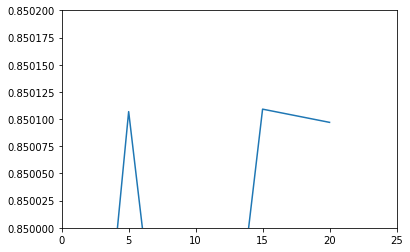

In [59]:
scores = plot_dict[best_model['criterion']] #matrix 16 depths x 21 min_sample_splits

scores_from_min_sample = [scores[best_model['max_depth']][min_samples] for min_samples in min_samples_range]
scores_from_max_depth = [scores[max_depth][best_model['min_samples_split']] for max_depth in depth_range]

l, = plt.plot(min_samples_range, scores_from_min_sample)

plt.xlim(0, 25)
plt.ylim(0.85, 0.8502)
plt.show()

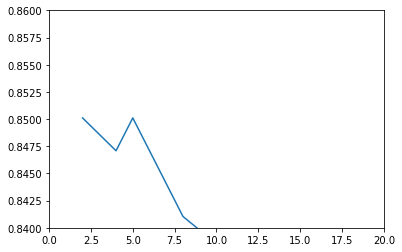

In [60]:
l, = plt.plot(depth_range, scores_from_max_depth)
plt.xlim(0, 20)
plt.ylim(0.84, 0.86)
plt.show()

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 123)

samp = best_model['min_samples_split']
depth = best_model['max_depth']
crit = best_model['criterion']

mytree = MyDecisionTreeClassifier(min_samples_split = samp, max_depth = depth, criterion = crit)

In [62]:
mytree.fit(X_train, y_train)
y_pred = mytree.predict(X_test)
print(accuracy_score(y_pred, y_test))

0.842964824120603


In [63]:
feat_imp = mytree.get_feature_importance()
sorted_indices = np.argsort(-feat_imp)

In [64]:
print(feat_imp[sorted_indices])

[0.81136532 0.5728534  0.46893491 0.41482767 0.36182569 0.35458724
 0.33519148 0.29439825 0.2854698  0.2554639  0.25375491 0.22862536
 0.21756762 0.21571314 0.19957785 0.15894485 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


In [65]:
ddf = df.drop(['match'], axis = 1)
features = ddf.columns.values
imp_feat = features[sorted_indices[:10]]
print(imp_feat)

['shar1_1' 'mn_sat' 'int_corr' 'imprace' 'race' 'attr2_1' 'sinc1_1' 'pid'
 'fun3_1' 'field_cd']


## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

